This report presents the results of training two Deep Learning architectures (MobileNetV2 and DenseNet121) with the CelebA dataset. MobileNetV2 and DenseNet121 are two of the Keras' pretrained networks that can be trained to classify images.

# Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Dropout, Dense, BatchNormalization
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications import DenseNet121


# Define Dataset Class

As in previous has been mentioned, CelebFaces Attributes Dataset (CelebA) is a large-scale face attributes dataset with 10177 identities and 202599 face images which are used for training and testing models for face attribute recognition, face recognition. 
In the following codes the class is defined to load images and desired attributes and also train, validation and test set.

In [2]:
class CelebA():
  '''Wraps the celebA dataset, allowing an easy way to:
       - Select the features of interest,
       - Split the dataset into 'training', 'test' or 'validation' partition.
  '''
  def __init__(self, main_folder=r'C:\Users\zeyna\data_faces', selected_features=None, drop_features=[]):
    self.main_folder = main_folder
    self.images_folder   = os.path.join(main_folder, 'img_align_celeba/')
    self.attributes_path = os.path.join(main_folder, 'list_attr_celeba.csv')
    self.partition_path  = os.path.join(main_folder, 'list_eval_partition.csv')
    self.selected_features = selected_features
    self.features_name = []
    self.__prepare(drop_features)

  def __prepare(self, drop_features):
    '''do some preprocessing before using the data: e.g. feature selection'''
    # attributes:
    if self.selected_features is None:
      self.attributes = pd.read_csv(self.attributes_path)
      self.num_features = 40
    else:
      self.num_features = len(self.selected_features)
      self.selected_features = self.selected_features.copy()
      self.selected_features.append('image_id')
      self.attributes = pd.read_csv(self.attributes_path)[self.selected_features]

    # remove unwanted features:
    for feature in drop_features:
      if feature in self.attributes:
        self.attributes = self.attributes.drop(feature, axis=1)
        self.num_features -= 1
      
    self.attributes.set_index('image_id', inplace=True)
    self.attributes.replace(to_replace=-1, value=0, inplace=True)
    self.attributes['image_id'] = list(self.attributes.index)
  
    self.features_name = list(self.attributes.columns)[:-1]
  
    # load ideal partitioning:
    self.partition = pd.read_csv(self.partition_path)
    self.partition.set_index('image_id', inplace=True)
  
  def split(self, name='training', drop_zero=False):
    '''Returns the ['training', 'validation', 'test'] split of the dataset'''
    # select partition split:
    if name == 'training':
      to_drop = self.partition.where(lambda x: x != 0).dropna()
    elif name == 'validation':
      to_drop = self.partition.where(lambda x: x != 1).dropna()
    elif name == 'test':  # test
      to_drop = self.partition.where(lambda x: x != 2).dropna()
    else:
      raise ValueError('CelebA.split() => `name` must be one of [training, validation, test]')

    partition = self.partition.drop(index=to_drop.index)
      
    # join attributes with selected partition:
    joint = partition.join(self.attributes, how='inner').drop('partition', axis=1)

    if drop_zero is True:
      # select rows with all zeros values
      return joint.loc[(joint[self.features_name] == 1).any(axis=1)]
    elif 0 <= drop_zero <= 1:
      zero = joint.loc[(joint[self.features_name] == 0).all(axis=1)]
      zero = zero.sample(frac=drop_zero)
      return joint.drop(index=zero.index)

    return joint

## Load Dataset

The face attributes recognition is a multi-target classification task in which there are 40 binary targets for each image. So , to implement our choices of deep learning model, four features out of 40 ('Smiling','Young','Bald','Straight_Hair') have been selected to be trained with Deep Neural Network.

In [3]:
# select desired features
celeba = CelebA(selected_features = ['Smiling','Young','Eyeglasses','Straight_Hair','Mustache'])
celeba.attributes.sample(5)

,Smiling,Young,Eyeglasses,Straight_Hair,Mustache,image_id
image_id,,,,,,
115369.jpg,0,1,0,0,0,115369.jpg
113074.jpg,0,1,0,0,0,113074.jpg
159090.jpg,1,1,0,0,0,159090.jpg
135776.jpg,0,0,0,0,1,135776.jpg
167768.jpg,0,1,0,0,0,167768.jpg


# Data Pre-processing

ImageDataGenerator function give us some options to do preprocessing as follows:
Normalization by dividing to 255
Generate batches of tensor image data with real-time data augmentation by rotating and shifting the images
The flow_from_dataframe() method takes the Pandas DataFrame and the path to a directory and generates batches of augmented/normalized data.

In [4]:
batch_size = 64

# augumentations for training set:
train_datagen = ImageDataGenerator(rotation_range=20, 
                                   rescale=1./255, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True, 
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

valid_datagen = ImageDataGenerator(rescale=1./255)


# get training and validation and test set:
train_split = celeba.split('training'  , drop_zero=False)
valid_split = celeba.split('validation', drop_zero=False)
test_split = celeba.split('test', drop_zero=False)

# data generators:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_split,
    directory=celeba.images_folder,
    x_col='image_id',
    y_col=celeba.features_name,
    target_size=(64, 64),
    batch_size=batch_size,
    class_mode='other'
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_split,
    directory=celeba.images_folder,
    x_col='image_id',
    y_col=celeba.features_name,
    target_size=(64, 64),
    batch_size=batch_size,
    class_mode='other'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_split,
    directory=celeba.images_folder,
    x_col='image_id',
    y_col=celeba.features_name,
    target_size=(64, 64),
    batch_size=batch_size,
    class_mode='other'
)

Found 162770 validated image filenames.
Found 19867 validated image filenames.
Found 19962 validated image filenames.


# Train with Deep Learning Model

## MobileNet V2
MobileNetV2 is one of the well-known convolutional neural network architectures with approximately 4M parameters. It is almost the same as the original MobileNet except that it uses inverted residual blocks with bottlenecking features. It reduces the parameter count than the original MobileNet.

In [5]:
# Build Model Architecture

def build_MobileNetV2_model(num_features):
  base = MobileNetV2(input_shape=(64, 64, 3),
                     weights=None,
                     include_top=False,
                     pooling='avg')  # GlobalAveragePooling 2D
  
  # Model Top
  x = base.output
  x = Dense(1536, activation='relu')(x)
  x = BatchNormalization()(x)
  x = Dropout(0.3)(x)
  top = Dense(num_features, activation='sigmoid')(x)
  
  return Model(inputs=base.input, outputs=top)

In [6]:
model_MobileNetV2 = build_MobileNetV2_model(num_features = celeba.num_features)
model_MobileNetV2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 32, 32, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 32, 32, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 32, 32, 32)   0           ['bn_Conv1[0][0]']               
                                                                                              

                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 8, 8, 144)   576         ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 8, 8, 144)    0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 8, 8, 32)     4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 8, 8, 32)    128         ['block_3_project[0][0]']        
 lization)                                                                                        
          

                                                                                                  
 block_7_expand_relu (ReLU)     (None, 4, 4, 384)    0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 4, 4, 384)   3456        ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 4, 4, 384)   1536        ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_depthwise_relu (ReLU)  (None, 4, 4, 384)    0           ['block_7_depthwise_BN[0][0]']   
          

 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 4, 4, 576)    55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 4, 4, 576)   2304        ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 4, 4, 576)    0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_depthwise (DepthwiseC  (None, 4, 4, 576)   5184        ['block_11_expand_relu[0][0]']   
 onv2D)   

 block_14_depthwise_relu (ReLU)  (None, 2, 2, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 2, 2, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 2, 2, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 2, 2, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
                                                                                                  
 block_15_

#  Define Optimizer and Loss Function
We need to use keras.metrics.BinaryAccuracy() for measuring the accuracy. Each element of prediction with the corresponding element of true labels. As we are dealing with multi-label classification and true labels are encoded multi-hot, we need to compare pairwise (binary!): each element of prediction with the corresponding element of true labels.

In [7]:
from keras import backend as K
import tensorflow as tf


def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1+K.epsilon())) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0 + K.epsilon()))
    return focal_loss_fixed

METRICS=['binary_accuracy',tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
model_MobileNetV2.compile(loss=focal_loss(), optimizer='adadelta', metrics = METRICS)

In [8]:
# Fitting the Model:

num_epochs = 50

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

history_MobileNetV2 = model_MobileNetV2.fit(
    train_generator,
    epochs=num_epochs,
    steps_per_epoch=len(train_generator),
    validation_data=valid_generator,
    validation_steps=len(valid_generator),
    max_queue_size=1,
    shuffle=True,
    callbacks=[callback],
    verbose=1)

model_MobileNetV2.save('model_MobileNetV2.h5')

Epoch 1/50
2544/2544 [==============================] - 941s 361ms/step - loss: 0.2628 - binary_accuracy: 0.5121 - precision: 0.3225 - recall: 0.5006 - val_loss: 0.1421 - val_binary_accuracy: 0.4899 - val_precision: 0.3342 - val_recall: 0.6446
Epoch 2/50
2544/2544 [==============================] - 868s 341ms/step - loss: 0.2096 - binary_accuracy: 0.5364 - precision: 0.3359 - recall: 0.4851 - val_loss: 0.1213 - val_binary_accuracy: 0.6077 - val_precision: 0.3985 - val_recall: 0.5124
Epoch 3/50
2544/2544 [==============================] - 815s 320ms/step - loss: 0.1766 - binary_accuracy: 0.5643 - precision: 0.3544 - recall: 0.4687 - val_loss: 0.0932 - val_binary_accuracy: 0.6295 - val_precision: 0.4100 - val_recall: 0.4352
Epoch 4/50
2544/2544 [==============================] - 761s 299ms/step - loss: 0.1514 - binary_accuracy: 0.5944 - precision: 0.3798 - recall: 0.4575 - val_loss: 0.1104 - val_binary_accuracy: 0.6472 - val_precision: 0.4319 - val_recall: 0.4254
Epoch 5/50
2544/2544 [==

2544/2544 [==============================] - 768s 302ms/step - loss: 0.0612 - binary_accuracy: 0.7464 - precision: 0.7195 - recall: 0.3174 - val_loss: 0.0703 - val_binary_accuracy: 0.7635 - val_precision: 0.7654 - val_recall: 0.3460
Epoch 35/50
2544/2544 [==============================] - 758s 298ms/step - loss: 0.0611 - binary_accuracy: 0.7469 - precision: 0.7211 - recall: 0.3187 - val_loss: 0.0687 - val_binary_accuracy: 0.7639 - val_precision: 0.7657 - val_recall: 0.3474
Epoch 36/50
2544/2544 [==============================] - 763s 300ms/step - loss: 0.0611 - binary_accuracy: 0.7476 - precision: 0.7234 - recall: 0.3197 - val_loss: 0.0683 - val_binary_accuracy: 0.7641 - val_precision: 0.7676 - val_recall: 0.3466
Epoch 37/50
2544/2544 [==============================] - 749s 294ms/step - loss: 0.0606 - binary_accuracy: 0.7477 - precision: 0.7260 - recall: 0.3177 - val_loss: 0.0674 - val_binary_accuracy: 0.7636 - val_precision: 0.7673 - val_recall: 0.3448
Epoch 38/50
2544/2544 [=========

#   Plot the training results of MobileNetV2

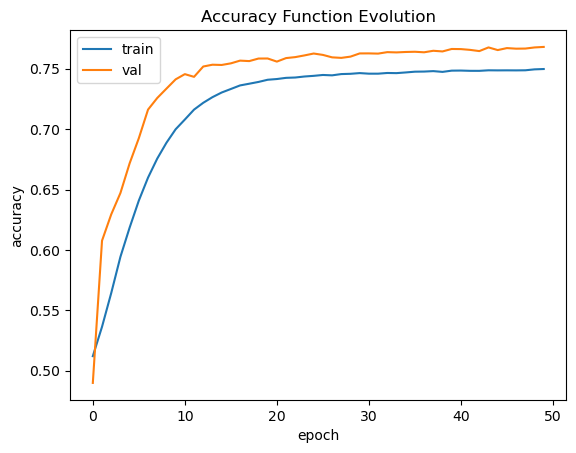

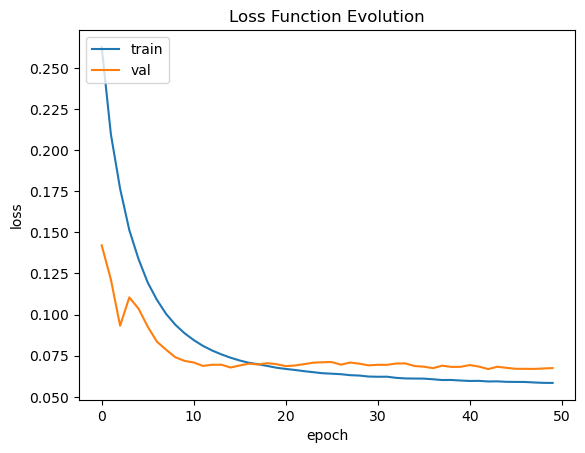

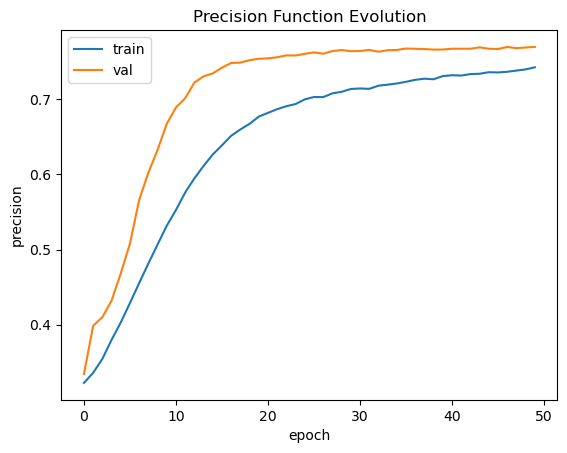

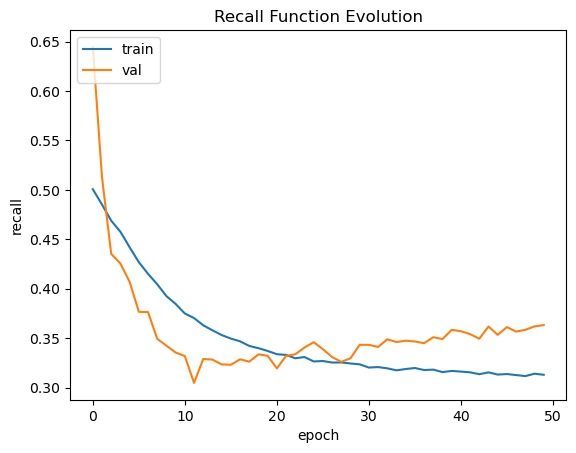

In [9]:
# Plot Training Results

plt.plot(history_MobileNetV2.history['binary_accuracy'])
plt.plot(history_MobileNetV2.history['val_binary_accuracy'])
plt.title('Accuracy Function Evolution')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history_MobileNetV2.history['loss'])
plt.plot(history_MobileNetV2.history['val_loss'])
plt.title('Loss Function Evolution')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history_MobileNetV2.history['precision'])
plt.plot(history_MobileNetV2.history['val_precision'])
plt.title('Precision Function Evolution')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history_MobileNetV2.history['recall'])
plt.plot(history_MobileNetV2.history['val_recall'])
plt.title('Recall Function Evolution')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [10]:
# Test the Model

scores_MobileNetV2 = model_MobileNetV2.evaluate(test_generator)
print("%s%s: %.2f%%" % ("Evaluate Accuracy:  ", model_MobileNetV2.metrics_names[1], scores_MobileNetV2[1]*100))

312/312 [==============================] - 55s 176ms/step - loss: 0.0665 - binary_accuracy: 0.7684 - precision: 0.7835 - recall: 0.3631
Evaluate Accuracy:  binary_accuracy: 76.84%


As the results demonstrates, the model is trained well and it can continue training with more epochs. the model have 76.33% accuracy on validation and 76.19% accuracy on test set. 

## DenseNet 121

DenseNet 121 is another well-known convolutional neural network architecture with approximately 8M parameters.

In [11]:
def build_DenseNet121_model(num_features):
  base = DenseNet121(input_shape=(64, 64, 3),
                     weights=None,
                     include_top=False,
                     pooling='avg')  # GlobalAveragePooling 2D
  
  # model top
  x = base.output
  x = Dense(1536, activation='relu')(x)
  x = BatchNormalization()(x)
  x = Dropout(0.3)(x)
  top = Dense(num_features, activation='sigmoid')(x)
  
  return Model(inputs=base.input, outputs=top)

In [12]:
model_DenseNet121 = build_DenseNet121_model(num_features=celeba.num_features)
model_DenseNet121.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)   0           ['input_2[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 32, 32, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1/conv[0][0]']             
                                                                                            

 conv2_block4_1_bn (BatchNormal  (None, 16, 16, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 16, 16, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block4_2_conv (Conv2D)   (None, 16, 16, 32)   36864       ['conv2_block4_1_relu[0][0]']    
                                                                                                  
 conv2_block4_concat (Concatena  (None, 16, 16, 192)  0          ['conv2_block3_concat[0][0]',    
 te)                                                              'conv2_block4_2_conv[0][0]']    
          

                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 8, 8, 128)   512         ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 8, 8, 128)   0           ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_2_conv (Conv2D)   (None, 8, 8, 32)     36864       ['conv3_block2_1_relu[0][0]']    
                                                                                                  
 conv3_block2_concat (Concatena  (None, 8, 8, 192)   0           ['conv3_block1_concat[0][0]',    
 te)      

 conv3_block6_2_conv (Conv2D)   (None, 8, 8, 32)     36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 8, 8, 320)   0           ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_block7_0_bn (BatchNormal  (None, 8, 8, 320)   1280        ['conv3_block6_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block7_0_relu (Activatio  (None, 8, 8, 320)   0           ['conv3_block7_0_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv3_block11_0_relu (Activati  (None, 8, 8, 448)   0           ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 8, 8, 128)    57344       ['conv3_block11_0_relu[0][0]']   
                                                                                                  
 conv3_block11_1_bn (BatchNorma  (None, 8, 8, 128)   512         ['conv3_block11_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_block11_1_relu (Activati  (None, 8, 8, 128)   0           ['conv3_block11_1_bn[0][0]']     
 on)      

 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 4, 4, 320)   0           ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 4, 4, 128)    40960       ['conv4_block3_0_relu[0][0]']    
                                                                                                  
 conv4_block3_1_bn (BatchNormal  (None, 4, 4, 128)   512         ['conv4_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_blo

 conv4_block7_1_bn (BatchNormal  (None, 4, 4, 128)   512         ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 4, 4, 128)   0           ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block7_2_conv (Conv2D)   (None, 4, 4, 32)     36864       ['conv4_block7_1_relu[0][0]']    
                                                                                                  
 conv4_block7_concat (Concatena  (None, 4, 4, 480)   0           ['conv4_block6_concat[0][0]',    
 te)                                                              'conv4_block7_2_conv[0][0]']    
          

                                                                                                  
 conv4_block11_concat (Concaten  (None, 4, 4, 608)   0           ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 4, 4, 608)   2432        ['conv4_block11_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block12_0_relu (Activati  (None, 4, 4, 608)   0           ['conv4_block12_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_blo

 conv4_block16_0_relu (Activati  (None, 4, 4, 736)   0           ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 4, 4, 128)    94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, 4, 4, 128)   512         ['conv4_block16_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_1_relu (Activati  (None, 4, 4, 128)   0           ['conv4_block16_1_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv4_block20_1_relu (Activati  (None, 4, 4, 128)   0           ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 4, 4, 32)     36864       ['conv4_block20_1_relu[0][0]']   
                                                                                                  
 conv4_block20_concat (Concaten  (None, 4, 4, 896)   0           ['conv4_block19_concat[0][0]',   
 ate)                                                             'conv4_block20_2_conv[0][0]']   
                                                                                                  
 conv4_block21_0_bn (BatchNorma  (None, 4, 4, 896)   3584        ['conv4_block20_concat[0][0]']   
 lization)

 ate)                                                             'conv4_block24_2_conv[0][0]']   
                                                                                                  
 pool4_bn (BatchNormalization)  (None, 4, 4, 1024)   4096        ['conv4_block24_concat[0][0]']   
                                                                                                  
 pool4_relu (Activation)        (None, 4, 4, 1024)   0           ['pool4_bn[0][0]']               
                                                                                                  
 pool4_conv (Conv2D)            (None, 4, 4, 512)    524288      ['pool4_relu[0][0]']             
                                                                                                  
 pool4_pool (AveragePooling2D)  (None, 2, 2, 512)    0           ['pool4_conv[0][0]']             
                                                                                                  
 conv5_blo

 conv5_block4_concat (Concatena  (None, 2, 2, 640)   0           ['conv5_block3_concat[0][0]',    
 te)                                                              'conv5_block4_2_conv[0][0]']    
                                                                                                  
 conv5_block5_0_bn (BatchNormal  (None, 2, 2, 640)   2560        ['conv5_block4_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block5_0_relu (Activatio  (None, 2, 2, 640)   0           ['conv5_block5_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block5_1_conv (Conv2D)   (None, 2, 2, 128)    81920       ['conv5_block5_0_relu[0][0]']    
          

 n)                                                                                               
                                                                                                  
 conv5_block9_1_conv (Conv2D)   (None, 2, 2, 128)    98304       ['conv5_block9_0_relu[0][0]']    
                                                                                                  
 conv5_block9_1_bn (BatchNormal  (None, 2, 2, 128)   512         ['conv5_block9_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block9_1_relu (Activatio  (None, 2, 2, 128)   0           ['conv5_block9_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_blo

 conv5_block13_1_relu (Activati  (None, 2, 2, 128)   0           ['conv5_block13_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block13_2_conv (Conv2D)  (None, 2, 2, 32)     36864       ['conv5_block13_1_relu[0][0]']   
                                                                                                  
 conv5_block13_concat (Concaten  (None, 2, 2, 928)   0           ['conv5_block12_concat[0][0]',   
 ate)                                                             'conv5_block13_2_conv[0][0]']   
                                                                                                  
 conv5_block14_0_bn (BatchNorma  (None, 2, 2, 928)   3712        ['conv5_block13_concat[0][0]']   
 lization)                                                                                        
          

__________________________________________________________________________________________________


#    Define Optimizer and Loss Function

In [13]:

METRICS=['binary_accuracy',tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
model_DenseNet121.compile(loss=focal_loss(), optimizer='adadelta', metrics = METRICS)

#   Fitting the Model

In [14]:
num_epochs = 50

history_DenseNet121 = model_DenseNet121.fit(
    train_generator,
    epochs=num_epochs,
    steps_per_epoch=len(train_generator),
    validation_data=valid_generator,
    validation_steps=len(valid_generator),
    max_queue_size=1,
    shuffle=True,
    callbacks=[callback],
    verbose=1)

model_DenseNet121.save('model_DenseNet121.h5')

Epoch 1/50
2544/2544 [==============================] - 836s 319ms/step - loss: 0.2413 - binary_accuracy: 0.5129 - precision: 0.3239 - recall: 0.5047 - val_loss: 0.1818 - val_binary_accuracy: 0.5357 - val_precision: 0.3322 - val_recall: 0.4874
Epoch 2/50
2544/2544 [==============================] - 767s 302ms/step - loss: 0.1905 - binary_accuracy: 0.5453 - precision: 0.3451 - recall: 0.4965 - val_loss: 0.1389 - val_binary_accuracy: 0.5906 - val_precision: 0.3760 - val_recall: 0.4788
Epoch 3/50
2544/2544 [==============================] - 764s 300ms/step - loss: 0.1558 - binary_accuracy: 0.5805 - precision: 0.3715 - recall: 0.4827 - val_loss: 0.1116 - val_binary_accuracy: 0.6351 - val_precision: 0.4194 - val_recall: 0.4495
Epoch 4/50
2544/2544 [==============================] - 735s 289ms/step - loss: 0.1313 - binary_accuracy: 0.6138 - precision: 0.4014 - recall: 0.4637 - val_loss: 0.0935 - val_binary_accuracy: 0.6826 - val_precision: 0.4886 - val_recall: 0.4324
Epoch 5/50
2544/2544 [==

2544/2544 [==============================] - 725s 285ms/step - loss: 0.0556 - binary_accuracy: 0.7736 - precision: 0.7907 - recall: 0.3810 - val_loss: 0.0466 - val_binary_accuracy: 0.7762 - val_precision: 0.8382 - val_recall: 0.3480
Epoch 35/50
2544/2544 [==============================] - 755s 297ms/step - loss: 0.0551 - binary_accuracy: 0.7740 - precision: 0.7933 - recall: 0.3804 - val_loss: 0.0475 - val_binary_accuracy: 0.7752 - val_precision: 0.8410 - val_recall: 0.3422
Epoch 36/50
2544/2544 [==============================] - 791s 311ms/step - loss: 0.0547 - binary_accuracy: 0.7749 - precision: 0.7956 - recall: 0.3827 - val_loss: 0.0466 - val_binary_accuracy: 0.7749 - val_precision: 0.8383 - val_recall: 0.3426
Epoch 37/50
2544/2544 [==============================] - 799s 314ms/step - loss: 0.0547 - binary_accuracy: 0.7749 - precision: 0.7965 - recall: 0.3820 - val_loss: 0.0466 - val_binary_accuracy: 0.7744 - val_precision: 0.8418 - val_recall: 0.3384
Epoch 38/50
2544/2544 [=========

#   Plot the training results of DenseNet121

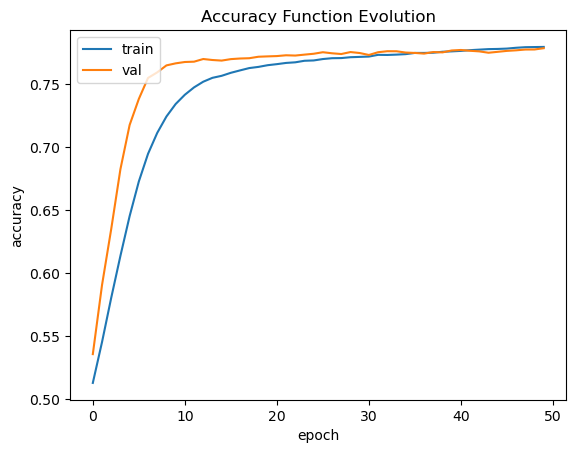

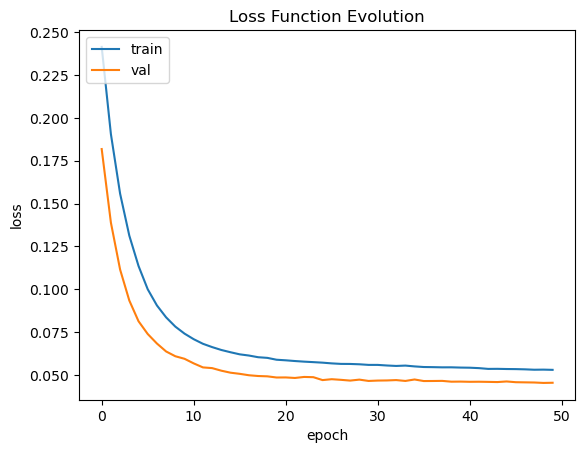

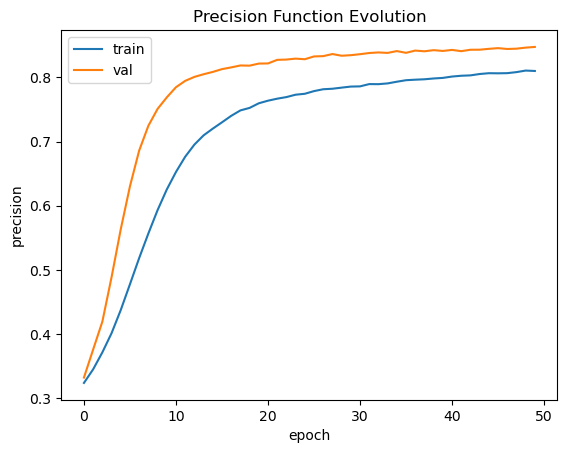

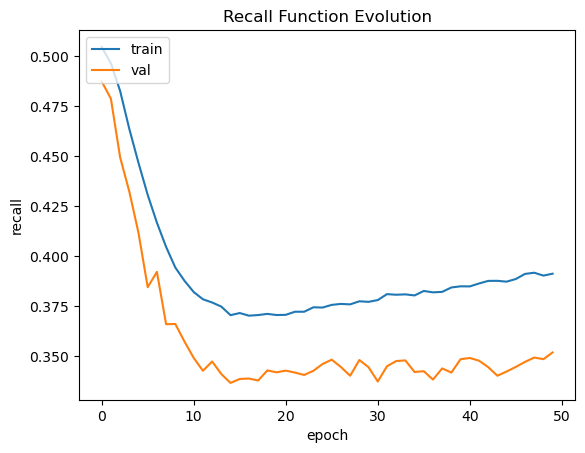

In [15]:
plt.plot(history_DenseNet121.history['binary_accuracy'])
plt.plot(history_DenseNet121.history['val_binary_accuracy'])
plt.title('Accuracy Function Evolution')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history_DenseNet121.history['loss'])
plt.plot(history_DenseNet121.history['val_loss'])
plt.title('Loss Function Evolution')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history_DenseNet121.history['precision'])
plt.plot(history_DenseNet121.history['val_precision'])
plt.title('Precision Function Evolution')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history_DenseNet121.history['recall'])
plt.plot(history_DenseNet121.history['val_recall'])
plt.title('Recall Function Evolution')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [16]:
# Test the Model

scores_DenseNet121 = model_DenseNet121.evaluate(test_generator)
print("%s%s: %.2f%%" % ("Evaluate Accuracy: ",model_DenseNet121.metrics_names[1], scores_DenseNet121[1]*100))


312/312 [==============================] - 44s 139ms/step - loss: 0.0457 - binary_accuracy: 0.7771 - precision: 0.8538 - recall: 0.3505
Evaluate Accuracy: binary_accuracy: 77.71%


As the results demonstrates, the model is trained well and it can continue training with more epochs. the model have 79.92% accuracy on validation and 79.72% accuracy on test set. 

# Conclusion

The results demonstrate that the DenseNet 121 model is more accurate than MobileNetV2. We can achieve better accuracy by changing the hyper-parameters or using other architectures. 
Deep Learning techniques tend to solve the problem end to end, whereas Machine learning techniques need the problem statements to break down into different parts to be solved first and then their results to be combined at the final stage. Deep learning is used to complete complex tasks and train models using unstructured data٫ used in image classification facial recognition. Although machine learning models can also identify faces, deep learning models are more accurate. While machine learning models can handle various types of data, they are limited when understanding unstructured data. This means that the knowledge hidden in this data may go unnoticed.
So The main advantage of deep learning over others ML methods is that its model is more accurate.